In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import dill as pickle

from IPython.display import clear_output

import dali.core as D
from dali.data import Lines, DiscoverFiles, BatchBenefactor
from dali.data.batch import TranslationBatch
from dali.data.translation import TranslationFiles, TranslationMapper, build_vocabs, iterate_examples

from dali.utils import (
    Vocab,
    median_smoothing,
    subsample,
    throttled,
    pickle_globals,
    unpickle_globals,
)
from dali import beam_search

%matplotlib inline

In [3]:
D.config.default_device = 'gpu'

# Data loading

In [4]:
# dataset
DATASET_PATH = "/home/sidor/datasets/translation/fr_en/europarl/"
FROM_LANG = "fr"
TO_LANG   = "en"
FROM_VOCAB_SIZE = 20000
TO_VOCAB_SIZE   = 20000

# batching
MINIBATCH = 128
SENTENCE_LENGTH_BOUNDS = (None, 21)
SENTENCES_UNTIL_MINIBATCH = 1000*MINIBATCH

# network sizes
INPUT_SIZE = 512
HIDDENS = [512,512,512,512]
SOFTMAX_INPUT = None

In [5]:
# you can press stop at any time if you think enough samples were collected.
vocabs = build_vocabs(DATASET_PATH, FROM_LANG, TO_LANG, from_max_size=FROM_VOCAB_SIZE, to_max_size=TO_VOCAB_SIZE)
print (FROM_LANG + " vocabulary containts", len(vocabs[0]), "words")
print (TO_LANG   + " vocabulary containts", len(vocabs[1]), "words")

Impatient User Detected, file processing halted, proceeding to build vocab.
fr vocabulary containts 20002 words
en vocabulary containts 20002 words


In [5]:
def create_dataset_iterator():
    return iterate_examples(DATASET_PATH, FROM_LANG, TO_LANG, vocabs, 
                            minibatch_size=MINIBATCH,
                            sentence_length_bounds=SENTENCE_LENGTH_BOUNDS,
                            sentences_until_minibatch=SENTENCES_UNTIL_MINIBATCH)

# Model definition 

In [6]:
class TranslationModel(object):
    def __init__(self, input_size, hiddens, 
                       encoder_vocab_size, decoder_vocab_size,
                       softmax_input_size=None, dtype=np.float32):
        self.input_size = input_size
        self.hiddens    = hiddens
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        self.softmax_input_size = softmax_input_size
        self.dtype = dtype
        
        self.encoder_embedding = D.random.uniform(-0.05, 0.05, (encoder_vocab_size, input_size), dtype=dtype)
        self.decoder_embedding = D.random.uniform(-0.05, 0.05, (decoder_vocab_size, input_size), dtype=dtype)
        
        self.encoder_lstm    = D.StackedLSTM(input_size, hiddens, shortcut=True, dtype=dtype)
        self.decoder_lstm    = D.StackedLSTM(input_size, hiddens, shortcut=True, dtype=dtype)
        
        if self.softmax_input_size is not None:
            self.predecoder = D.Layer(self.hiddens[-1], self.softmax_input_size)
            self.decoder = D.Layer(self.softmax_input_size, decoder_vocab_size, dtype=dtype)
        else:    
            self.decoder = D.Layer(hiddens[-1], decoder_vocab_size, dtype=dtype)
    
    def decode_state(self, state):
        if self.softmax_input_size is not None:
            decoder_input = self.predecoder.activate(state[-1].hidden)
        else:
            decoder_input = state[-1].hidden
        return self.decoder.activate(decoder_input)
        
    def error(self, batch):
        error = D.Mat(1,1)
        state = self.encoder_lstm.initial_states()
        for ts in range(batch.timesteps):
            inputs  = batch.inputs(ts)
            targets = batch.targets(ts)
            if ts < batch.from_timesteps:
                assert targets is None
                encoded = self.encoder_embedding[inputs]
                state = self.encoder_lstm.activate(encoded, state)
            else:
                assert inputs is None
                decoded = self.decode_state(state)
                # mask the error - only for the relevant sentences
                tstep_error = batch.masks(ts).T() * D.MatOps.softmax_cross_entropy(decoded, targets)
                #tstep_error = D.MatOps.softmax_cross_entropy(decoded, targets)
                error = error + tstep_error.sum()
                # feedback the predictions
                if ts + 1 != batch.timesteps:
                    # for the last timestep encoding is not necessary
                    encoded = self.decoder_embedding[targets]
                    state = self.decoder_lstm.activate(encoded, state)

        return error
    
    def sample(self, input_sentence, temperature=1.0, **kwargs):
        with D.NoBackprop():
            state = self.encoder_lstm.initial_states()
            for word_idx in input_sentence:
                encoded = self.encoder_embedding[word_idx]
                state = self.encoder_lstm.activate(encoded, state)
            def candidate_scores(state):
                decoded = self.decode_state(state)
                return D.MatOps.softmax(decoded, temperature=temperature).log()
            def make_choice(state, candidate_idx):
                encoded = self.decoder_embedding[candidate_idx]
                return self.decoder_lstm.activate(encoded, state)

            return beam_search(state,
                               candidate_scores,
                               make_choice,
                               **kwargs)
    
    def parameters(self):
        ret = ([self.encoder_embedding,
               self.decoder_embedding]      
            + self.encoder_lstm.parameters() 
            + self.decoder_lstm.parameters() 
            + self.decoder.parameters())
        if self.softmax_input_size is not None:
            ret.extend(self.predecoder.parameters())
        return ret

In [7]:
def show_reconstructions(model, example_pair, temperature=1.0):
    from_words, to_words = example_pair
    from_vocab, to_vocab = vocabs
    from_with_unk = ' '.join(from_vocab.decode(from_vocab.encode(from_words)))
    to_with_unk   = ' '.join(to_vocab.decode(to_vocab.encode(to_words)))
    print('TRANSLATING: %s' % from_with_unk)
    print('REFERENCE:   %s' % to_with_unk)
    print('')
    for solution, score, _ in model.sample(from_vocab.encode(from_words, True), 
                                           eos_symbol=to_vocab.eos,
                                           max_sequence_length=SENTENCE_LENGTH_BOUNDS[1] + 1,
                                           blacklist=[], #to_vocab.unk],
                                           temperature=temperature):
        score = math.exp(score.w[0])
        # reveal the unks
        solution = ' '.join(to_vocab.decode(solution, False))
        print('    %f => %s' % (score, to_vocab.decode(solution, True)))

# Create new experiment 

In [9]:
model  = TranslationModel(INPUT_SIZE, HIDDENS, len(vocabs[0]), len(vocabs[1]), softmax_input_size=SOFTMAX_INPUT)

In [10]:
params = model.parameters()
solver = D.SGD(params)
solver.step_size = 0.001
# solver = D.AdaDelta(params, rho=0.95)

In [11]:
data            = []
error_evolution = []
epoch_error     = []

# (Optional) continue running previous attempt 

In [8]:
if False:
    unpickle_globals("/home/sidor/tmp/translation_exp/epoch_3")
    params = model.parameters()

In [14]:
model.decoder_lstm.shortcut = True

# Training

In [15]:
D.config.clear_gpu()

total_error = 0.0
total_time  = 0.0
num_words, num_targets, num_batches = 0, 0, 0

@throttled(5)
def report(example):
    if num_batches == 0 or num_words == 0 or abs(total_time) < 1e-6:
        return
    clear_output()
    print('Epochs completed:  ', len(error_evolution))
    print('Error:             ', total_error / num_batches)
    print('Time per batch:    ', total_time  / num_batches)
    print('Words per second:  ', num_words   / total_time )
    print('Batches processed: ', num_batches)
    if hasattr(solver, 'step_size'):
        print('Solver step size:  ', solver.step_size)
    show_reconstructions(model, example)
    sys.stdout.flush()
    

batch_end_time, batch_start_time = None, None

while True:
    if len(error_evolution) > 40:
        break
        
    #if len(error_evolution) >= 5 and hasattr(solver, 'step_size'):
    #solver.step_size = solver.step_size / 1.5
        
    for batch in data:    
        example_pair = random.choice(batch.sentence_pairs)
        report(example_pair) 
            
        batch_start_time = time.time()
        error = model.error(batch)

        (error / batch.examples).grad()
        D.Graph.backward()
        solver.step(params)
        batch_end_time = time.time()

        epoch_error.append(error.w[0,0] / batch.to_tokens)
        
        total_error   += error.w[0, 0] / batch.to_tokens
        total_time += batch_end_time - batch_start_time

        num_words   += batch.from_tokens + batch.to_tokens
        num_targets += batch.from_tokens + batch.to_tokens
        num_batches += 1

        # free memory as soon as possible
        del batch

    if len(epoch_error) > 0:
        epoch_error = subsample(epoch_error, maximum_length=1000)
        error_evolution.append(epoch_error)
        epoch_error = []
        pickle_globals("/home/sidor/tmp/translation_exp/epoch_%d" % (len(error_evolution),),
                       ["model", "vocabs", "solver", "data", "error_evolution", "epoch_error"])
            
    data = create_dataset_iterator()

Epochs completed:   4
Error:              5.2384602145
Time per batch:     0.5359211661900549
Words per second:   6547.205335994846
Batches processed:  4886
Solver step size:   0.009999999776482582
TRANSLATING: Le rapport de M . Morillon donne une impulsion très claire à cela .
REFERENCE:   Mr Morillon ' s report gives a very clear boost to this .

    0.055378 => What was . **EOS**
    0.050178 => Finally : **EOS**
    0.008456 => When **UNK** ) **EOS**
    0.000000 => What would of the role . I am a question - and gentlemen . **EOS**
    0.000000 => What would of the role . I am a question of the question - and gentlemen . **EOS**


KeyboardInterrupt: 

In [14]:
pickle_globals("/home/sidor/tmp/translation_big_lr", ["model", "vocabs", "solver", "data", "error_evolution"])

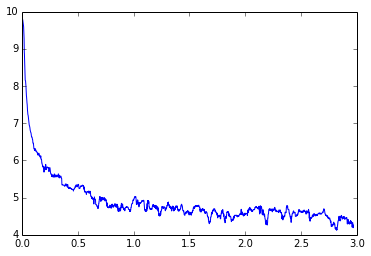

In [9]:
def flatten_error():
    x = []
    y = []
    for epoch_no, error_epoch in enumerate(error_evolution):
        x.extend(float(epoch_no) + float(t) / len(error_epoch) for t in range(len(error_epoch)))
        y.extend(error_epoch)
        
    y = median_smoothing(y, 30)
    x = x[:len(y)]
    return x,y
    
plt.plot(*flatten_error())

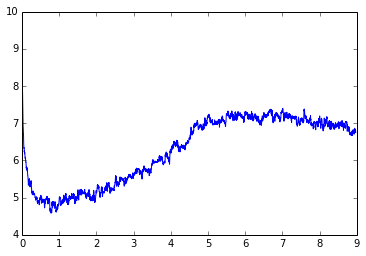

In [13]:
# 0.02 learning rate Jonathan's weights, divide by 1.5 every epoch (starting at fifth)

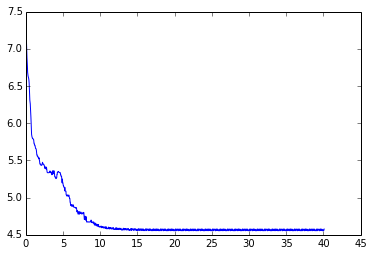

In [575]:
# 0.3 learning rate Jonathan's weights, divide by 2 every epoch 

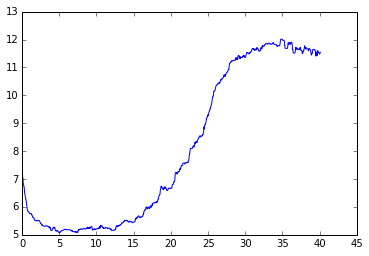

In [559]:
# 0.03 learning rate Jonathan weights

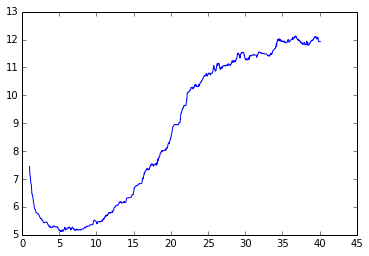

In [553]:
# 0.03 learning rate Jonathan weights

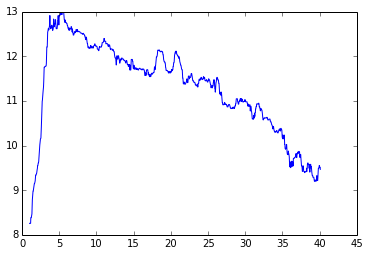

In [547]:
# 0.3 learning rate Jonathan weights

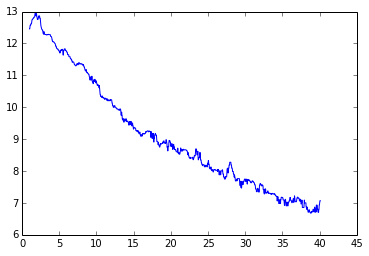

In [541]:
# 0.3 learning rate, torch weight init

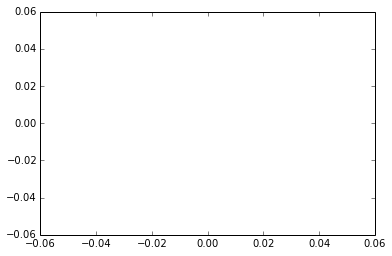

In [431]:
r= epoch_error#median_smoothing(epoch_error, window=500)

plt.plot(range(len(r)), r)

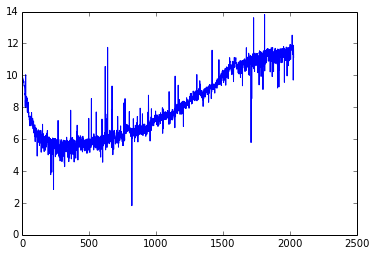

In [19]:
plt.plot(range(len(epoch_error)), epoch_error)